In [2]:
from numpy import array
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib as mp
import time
import seaborn as sb
import matplotlib as mpl 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Sections of the report 

-	Abstract
-	Introduction
-	Methods
    -	Cleaning the data and creating new input features
    - Analysing and visualising the data
    - Preparing the inputs and choosing suitable features
    - Selecting and training a model
- Training the model
- K fold cross validation
- Fine-tuning the models
-	Evaluation
-	Discussion 
-	Conclusion


## 1. Introduction

This study will be taking a data driven approach towards classifying images of seals. The dataset used 

## 2. Method

### 2.1 Loading and cleaning the data set


In [3]:
# Load the datasets

#binary datasets
X_train_binary = pd.read_csv('/data/CS5014-P2/binary/X_train.csv', header=None)
Y_train_binary = pd.read_csv('/data/CS5014-P2/binary/Y_train.csv', header=None)
X_test_binary = pd.read_csv('/data/CS5014-P2/binary/X_test.csv', header=None)

#multi datasets
X_train_multi = pd.read_csv('/data/CS5014-P2/multi/X_train.csv', header=None)
Y_train_multi = pd.read_csv('/data/CS5014-P2/multi/Y_train.csv', header=None)
X_test_multi = pd.read_csv('/data/CS5014-P2/multi/X_test.csv', header=None)

###  Cleaning the dataset

a) **Check for Null-values and inconsistent data types:** Upon looking at that dataset, we can see that each column has an equal amount of non-null values, indicating that there are **no instances** of missing data. Moreover, all the data types are float64, indicating a consistency in data format

In [4]:
# Check for Null-values
print(X_train_multi.info(null_counts=True))
print(X_train_binary.info(null_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62210 entries, 0 to 62209
Columns: 964 entries, 0 to 963
dtypes: float64(964)
memory usage: 457.5 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62210 entries, 0 to 62209
Columns: 964 entries, 0 to 963
dtypes: float64(964)
memory usage: 457.5 MB
None


b) **Check for duplicate values**: No duplicate values were found

In [7]:
# remove duplicate rows
datasets = [X_train_binary,Y_train_binary, X_test_binary, X_train_multi, X_train_multi, X_test_multi]

for data in datasets:
    duplicate_rows = data[data.duplicated()]
    print(len(duplicate_rows))

0
62208
0
0
0
0


No null values, no duplicate and all the data types were for the dtype float64. Nothing needed to change so will proceed to visualising the dataset


### 2.2 Create a preliminary test set

Despite there being a already a test set in place, a preliminary test set was created, to evaluate the performance of the model and to see how well the model could
generalise on unseen data. The training data was split with an 80/20 split in stratified fashion, in order to keep the proportion of the classes as the dataset
was already heavily imbalanced.

In [8]:
# Splits the training set
X_train_B, X_pre_test_B, y_train_B, y_pre_test_B = train_test_split(X_train_binary, Y_train_binary, test_size=0.20, stratify=Y_train_binary, random_state=27)
X_train_M, X_pre_test_M, y_train_M, y_pre_test_M = train_test_split(X_train_multi, Y_train_multi, test_size=0.20, stratify=Y_train_multi, random_state=27)

# Resets the indexes
X_train_B = X_train_B.reset_index(drop=True)
X_pre_test_B = X_pre_test_B.reset_index(drop=True)
y_train_B = y_train_B.reset_index(drop=True)
y_pre_test_B = y_pre_test_B.reset_index(drop=True)

X_train_M = X_train_M.reset_index(drop=True)
X_pre_test_M = X_pre_test_M.reset_index(drop=True)
y_train_M = y_train_M.reset_index(drop=True)
y_pre_test_M = y_pre_test_M.reset_index(drop=True)

### 2.2 Analysing and Visualising the dataset

#### 2.2.1 Visualising the images


The dataset has 62210 images, with around 964 features. To visualise the images, I sliced the first
900 columns to get the Histogram of Orientated Gradient (HOG) features and picked an image from each class found in the Y_train datasets

Figure 1 below, showes the images taken from the binary dataset, where classes are either background and seal. 
Figure 2, shows images from the multi dataset, where images are background, dead pup, whitecoat, moulted pup, juvenile

In [9]:
bin_classes = ['background','seal']
mult_classes = ['background','dead pup', 'whitecoat', 'moulted pup', 'juvenile']

def get_rows_and_titles(classes, dataset, num):
    rows = np.array([])
    titles = np.array([])
    for i in classes:
        filt = dataset.iloc[:,0] == i
        filtered_data = dataset[filt].head(num)
        rows = np.concatenate([rows, filtered_data.index.values])
        titles = np.concatenate([titles, array(filtered_data.iloc[:,0])])
    
    return rows.astype(int), titles  
      
        
bin_rows, bin_titles = get_rows_and_titles(bin_classes, y_train_B,5)
mult_rows, mult_titles = get_rows_and_titles(mult_classes, y_train_M,2)



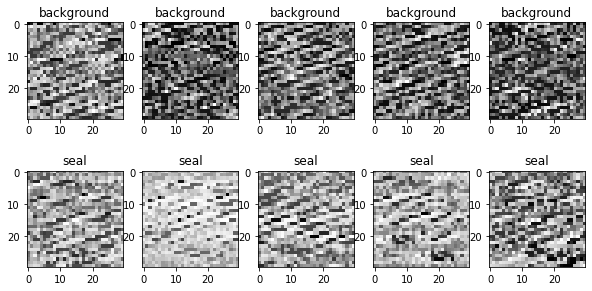

In [10]:
# classes in the  binary dataset
no_rows_bin  = 2
no_rows_mult = 2
def print_images(no_rows,row_numbers, titles, dataset, width, height): 
    fig = plt.figure(figsize=(width, height))
    for i in range(1, len(row_numbers) +1): 
        output = array(dataset.iloc[row_numbers[i-1], :900])
        output_image = output.reshape(30, 30)
        fig.add_subplot(no_rows, 5, i)
        plt.imshow(output_image, cmap = mpl.cm.binary, interpolation="nearest")
        plt.title(titles[i-1])
        plt.axis("on")
        
    plt.show()

print_images(no_rows_bin, bin_rows, bin_titles, X_train_B,10,5)

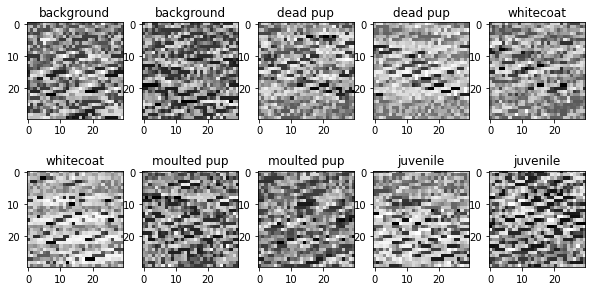

In [11]:
print_images(no_rows_mult, mult_rows, mult_titles, X_train_M,10,5)

In both datasets, we can see that the "backgound" classes appears to have the least amount of dark pixelation compared to the others. 
In the mult-classification dataset, the whitecoat image appears to be the most distinct

#### 2.2.2 Visualising the class distribution in the data

To understand the distribution of the classes in both the binary and multi datasets, I visualised the frequency distribution of the classes


In [12]:
# prepare data for visualisation
bin_freq= y_train_B.iloc[:,0].value_counts()
mult_freq= y_train_M.iloc[:,0].value_counts()

mult_classes = array(mult_freq.keys())
mult_data = mult_freq.values
bin_classes = array(bin_freq.keys())
bin_data = bin_freq.values

classes = [mult_classes, bin_classes]
mult_and_bin_freq = [mult_data, bin_data]
titles = ["Multi","Binary"]


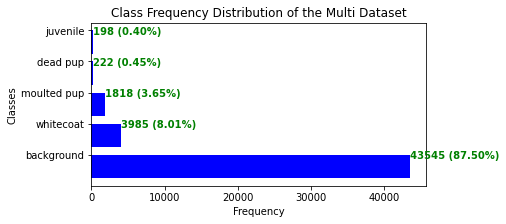

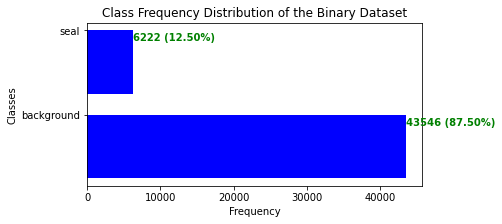

In [13]:
# X_train_multi.iloc[:,0].value_counts().plot(kind='barh') #horizontal bar plot

def get_pct(array, value):
    pct = value/array.sum()
    pct_string =  " ({:.2%})".format(pct)
    return pct_string
#
def plot_class_dist(data,classes, title):
    fig, ax = plt.subplots(figsize=(6, 3))    
    width = 0.75 # the width of the bars 
    ind = np.arange(len(data))  # the x locations for the groups
    ax.barh(ind, data, width, color="blue")
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(classes, minor=False)
    plt.title("Class Frequency Distribution of the " + title +  " Dataset")
    plt.xlabel('Frequency')
    plt.ylabel('Classes')
    for i, v in enumerate(data):
        ax.text(v + 3, i + .25, str(v) + get_pct(data,v), color='green', fontweight='bold')
    plt.show()
    
for i in range(2):
    plot_class_dist(mult_and_bin_freq[i],classes[i],titles[i])

It is evident that both datasets are heavily skewed towards the background class, accounting for 87.5% of the dataset. Given this large proportion of the background class in the dataset,
it may be no suprise that the classification algorithm is able to classify the background class very well. On the other hand, the juvenile and moulted pup classes
account for 0.40% and 0.45% respectively. Given the skewed data set it will make sense to stratify the training sets to keep a consistent distribution. 

#### 2.2.3 Visualising Variance Using PCA and t-SNE

**PCA**

PCA is a technique for reducing the number of dimensions in a dataset whilst retaining most information. It is using the correlation between some dimensions and tries to provide a minimum number of variables that keeps the maximum amount of variation or information about how the original data is distributed.
https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

The explained variance ratio indicates the proportion of the dataset’s variance that lies along the axis of each principal component. Therefore 35.6% of the datasets variance lies in the first axis, 20.1% in the 2nd axis and 14% in the 3rd axis. Hence the first three components account for 69.7% of the entire dataset, lets see if that is enough to visually set the classes apart 

PCA identifies the axis that accounts for the largest amount of variance in the training set. It then finds a 2nd axis which is orthogonal to the first and 3rd which is orthogonal to both axes. 

We can see from Figure 3, that data relating to the seal has the highest variance as it dominates the X axis of PCA 1. The data relating to background, appears to have a lower variance as it appears for the highest PCA values for PCA 2


**t-SNE**

original paper = http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf
t-Distributed Stochastic Neighbor Embedding (t-SNE) is another technique for dimensionality reduction and is particularly well suited for the visualization of high-dimensional datasets. Contrary to PCA it is not a mathematical technique but a probablistic one.


In [ ]:
# scale binary dataset
std_B = StandardScaler().fit(X_train_B)
X_train_B_std = std_B.transform(X_train_B)

# scale multi dataset
std_M = StandardScaler().fit(X_train_M)
X_train_M_std = std_M.transform(X_train_M)

# data lists
X_train_std_list = [X_train_M_std, X_train_B_std]
X_train_list = [X_train_M,X_train_B]
Y_train_list = [y_train_M,y_train_B]
no_colors = [5,2]

def plot_pca_and_tsne(x_train,y_train, no_colors, title):
    # prepare data for visualisation
    y = array(y_train.iloc[:,0])
    feat_cols = ['pixel'+str(i) for i in range(X_train_B.shape[1])]
    df = pd.DataFrame(array(x_train), columns=feat_cols)
    df['y'] = y
    df['label'] = df['y'].apply(lambda i: str(i))

    X, y = None, None
    
    # add random perm
    np.random.seed(42)
    rndperm = np.random.permutation(x_train.shape[0])

    # Set PCA components
    N = 10000
    df_subset = df.loc[rndperm[:N],:].copy()
    data_subset = df_subset[feat_cols].values
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(data_subset)
    df_subset['pca-one'] = pca_result[:,0]
    df_subset['pca-two'] = pca_result[:,1] 
    df_subset['pca-three'] = pca_result[:,2]
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

    # Set TSNE components
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(data_subset)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    df_subset['tsne-2d-one'] = tsne_results[:,0]
    df_subset['tsne-2d-two'] = tsne_results[:,1]
    
    # plot PCA and TSNE components
    plt.figure(figsize=(16,7))
    ax1 = plt.subplot(1, 2, 1)
    sb.scatterplot(
        x="pca-one", y="pca-two",
        hue="y",
        palette=sb.color_palette("hls", no_colors),
        data=df_subset,
        legend="full",
        alpha=0.3,
        ax=ax1
    )
    ax1.set_title(title + " dataset")
    ax2 = plt.subplot(1, 2, 2)
    sb.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        palette=sb.color_palette("hls", no_colors),
        data=df_subset,
        legend="full",
        alpha=0.3,
        ax=ax2
    )
    ax2.set_title(title + " dataset")
    
for i in range (2):
    plot_pca_and_tsne(X_train_std_list[i], Y_train_list[i], no_colors[i], titles[i])

Explained variation per principal component: [0.09087661 0.06528279 0.05017037]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 1.507s...


### 2.3 Preparing the inputs and choosing suitable features (TODO)

- Discuss about the features and their properties i.e HOG features, their importance and everything else
- Understand the correlation of the features with one another


To have a better understanding of how the features related with one a

#### 2.3.1 Choosing Suitable features 

Since the data is split up into three different groups, I decided to test different feature subsets using a baseline logistic regression, in order to choose a 
specific subset for further training and optimising. 

In [39]:
# Binary dataset feature subsets
X_train_B_HoG = X_train_B.iloc[:, :900]
X_train_B_normal = X_train_B.iloc[:, 900:916]
X_train_B_colour = X_train_B.iloc[:, 916:964]
X_train_B_list=[X_train_B, X_train_B_HoG, X_train_B_normal, X_train_B_colour]

# Binary dataset feature subsets
X_train_M_HoG = X_train_B.iloc[:, :900]
X_train_M_normal = X_train_B.iloc[:, 900:916]
X_train_M_colour = X_train_B.iloc[:, 916:964]
X_train_M_list=[X_train_M, X_train_M_HoG, X_train_M_normal, X_train_M_colour]


#### 2.3.2 Scaling

Would be interesting to see how scaling affects the performance. Given that the Hog Features data set performaed the best, I decided 
to focus on scaling this for both the multi and binary data sets to see if this would imporve performance



In [40]:
# scale binary dataset
std_B_HoG = StandardScaler().fit(X_train_B_HoG)
X_train_B_std_HoG = std_B_HoG.transform(X_train_B_HoG)

# scale multi dataset
std_M_HoG = StandardScaler().fit(X_train_M_HoG)
X_train_M_std_HoG = std_M_HoG.transform(X_train_M_HoG)

#### 2.3.3 Dimensionality reduction with PCA

Earlier dimensionality reduction was used for visualisation, now it will be used for training and evaluation purposes. As opposed to only used 2 principal components
, the aim would be to find the optimal amount of principal components so as to reduce the dimensions while having a high amount of variance in the data > 95%


In [48]:
pca = PCA()
pca.fit(X_train_B_std_HoG)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.99) + 1
d

444

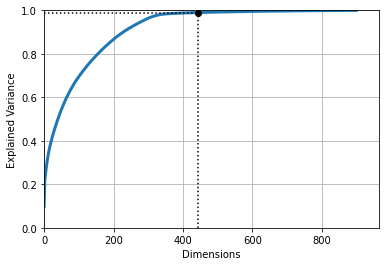

In [51]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 964, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.99], "k:")
plt.plot([0, d], [0.99, 0.99], "k:")
plt.plot(d, 0.99, "ko")
plt.grid(True)
plt.show()

#### 2.3.4 Resampling

To address the issue of having an unbalanced dataset, this study investigated resampling techniques such as oversampling and undersampling

- Oversampling: Oversampling can be defined as adding more copies of the minority class. Oversampling can be a good choice when you don’t have a ton of data to work with.
- 

## 3 Training The Model 

### 3.1 Models used 

- Logistic regression
- SVM
- MLP
- Random Forrest 

### 3.2 Out of the box classifier

The first models that I will use are logistic regression and SVM

In [17]:
#fit the logistic regression


def run_rf(X, Y):
    """
    Runs the Random Forest classifier using 3 fold cross validation. Trains the model 
    and scores it on the given dataset, providing results for accuracy, precision, recall, f1 score
    and a confusion matrix
    :return: log
    """""
    Y = Y.values.ravel()
    results = {}
    rf = RandomForestClassifier(max_depth=10, n_estimators=10, random_state=0, n_jobs=-1).fit(X, Y)
    scores = cross_val_score(rf, X, Y, cv=3, scoring="accuracy")
    avg_accuracy = sum(scores)/len(scores)
    Y_pred = cross_val_predict(rf, X, Y, cv=3)
    cm = confusion_matrix(Y, Y_pred)   
    results["Accuracy"] = sum(scores)/len(scores)
    results["Precision"] = precision_score(Y, Y_pred, pos_label='seal')
    results["Recall"] = recall_score(Y, Y_pred, pos_label='seal')
    results["F1 Score"] = f1_score(Y, Y_pred, pos_label='seal')
    print("Random Forest Performance Results: \n" + str(results))
    print(cm) 
    return rf, results


def run_log(X, Y):
    """
    Runs the Logistic regression classifier using 3 fold cross validation. Trains the model 
    and scores it on the given dataset, providing results for accuracy, precision, recall, f1 score
    and a confusion matrix
    :return: log
    """""
    Y = Y.values.ravel()
    results = {}
    log = LogisticRegression(random_state=0).fit(X, Y)
    scores = cross_val_score(log, X, Y, cv=3, scoring="accuracy")
    avg_accuracy = sum(scores)/len(scores)
    Y_pred = cross_val_predict(log, X, Y, cv=3)
    cm = confusion_matrix(Y, Y_pred)   
    results["Accuracy"] = sum(scores)/len(scores)
    results["Precision"] = precision_score(Y, Y_pred, pos_label='seal')
    results["Recall"] = recall_score(Y, Y_pred, pos_label='seal')
    results["F1 Score"] = f1_score(Y, Y_pred, pos_label='seal')
    print("Logistic Regression Performance Results: \n" + str(results))
    print(cm) 
    return log, results



# Y = X_train_multi.values.ravel()
# run_svc(X_train_B,Y)
# log = LogisticRegression(random_state=0).fit(X_train_B,Y)
# print("Logistic Regression Test Score: {0}".format(log.score(X_train_B,Y)))

time_start = time.time()
for i in range (len(X_train_B_list)):
    run_log(X_train_B_list[i], Y_train_B)
print('Prediction done! Time elapsed: {} seconds'.format(time.time()-time_start))

time_start = time.time()
for i in range (len(X_train_B_list)):
    run_rf(X_train_B_list[i], Y_train_B)
print('Prediction done! Time elapsed: {} seconds'.format(time.time()-time_start))

/cs/home/ybk1/Documents/Modules/CS5014/Classification/env/lib64/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cs/home/ybk1/Documents/Modules/CS5014/Classification/env/lib64/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative 

Logistic Regression Performance Results: 
{'Accuracy': 0.889165578021661, 'Precision': 0.6608378870673952, 'Recall': 0.23322190794548728, 'F1 Score': 0.34476860210966453}
[[53501   931]
 [ 5964  1814]]


/cs/home/ybk1/Documents/Modules/CS5014/Classification/env/lib64/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cs/home/ybk1/Documents/Modules/CS5014/Classification/env/lib64/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative 

Logistic Regression Performance Results: 
{'Accuracy': 0.9632371397068439, 'Precision': 0.9196087421672016, 'Recall': 0.7735921830804834, 'F1 Score': 0.8403044480134069}
[[53906   526]
 [ 1761  6017]]


/cs/home/ybk1/Documents/Modules/CS5014/Classification/env/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic Regression Performance Results: 
{'Accuracy': 0.8749718699265404, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0}
[[54432     0]
 [ 7778     0]]


/cs/home/ybk1/Documents/Modules/CS5014/Classification/env/lib64/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cs/home/ybk1/Documents/Modules/CS5014/Classification/env/lib64/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative 

Logistic Regression Performance Results: 
{'Accuracy': 0.8889083926545482, 'Precision': 0.6602587800369686, 'Recall': 0.22962201079969144, 'F1 Score': 0.34074215396356006}
[[53513   919]
 [ 5992  1786]]
Prediction done! Time elapsed: 93.72429370880127 seconds
Random Forest Performance Results: 
{'Accuracy': 0.9573376784994556, 'Precision': 0.966326902074991, 'Recall': 0.6825662123939316, 'F1 Score': 0.8000301386377335}
[[54247   185]
 [ 2469  5309]]
Random Forest Performance Results: 
{'Accuracy': 0.9576752781404423, 'Precision': 0.9629296382940435, 'Recall': 0.6879660581126253, 'F1 Score': 0.8025496812898387}
[[54226   206]
 [ 2427  5351]]


/cs/home/ybk1/Documents/Modules/CS5014/Classification/env/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest Performance Results: 
{'Accuracy': 0.8749718699265404, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0}
[[54432     0]
 [ 7778     0]]
Random Forest Performance Results: 
{'Accuracy': 0.928033598501446, 'Precision': 0.8774296821404071, 'Recall': 0.4933144767292363, 'F1 Score': 0.6315529586042301}
[[53896   536]
 [ 3941  3837]]
Prediction done! Time elapsed: 1840.5552034378052 seconds
